In [1]:
from src.OPFInterface import OPFClassifier # c++
from src.py_opf import OptimumPathForestClassifier # py
from functools import cmp_to_key
import pandas as pd
import numpy as np
from os import listdir
import seaborn as sns
from src.utils import error, read_df, euclidean_distance_classify, dtw_distance_classify
from tqdm import tqdm
from time import time
# plot
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [2]:
datasets_df = pd.read_csv('data/DataSummary.csv')

df_names = ["WordSynonyms", "SemgHandSubjectCh2", "PLAID", "MelbournePedestrian", "ChlorineConcentration", "ShapesAll"]
new_df = datasets_df.loc[datasets_df['Name'].isin(df_names)].set_index('Name')
new_df.loc[df_names].reset_index().drop(columns=['ID', 'DTW (learned_w) ', 'Data donor/editor', 'Default rate'])

Name      Type  Train   Test   Class  Length  ED (w=0)  \
0           WordSynonyms     Image     267    638     25     270    0.3824   
1     SemgHandSubjectCh2  Spectrum     450    450      5    1500    0.5956   
2                  PLAID    Device     537    537     11    1344    0.4767   
3    MelbournePedestrian   Traffic    1194   2439     10      24    0.1525   
4  ChlorineConcentration    Sensor     467   3840      3     166    0.3500   
5              ShapesAll     Image     600    600     60     512    0.2483   

   DTW (w=100)  
0       0.3511  
1       0.2733  
2       0.1639  
3       0.2091  
4       0.3516  
5       0.2317

In [4]:
df = pd.read_csv('results/all_errors.csv')
df = df[['1NN-ED', 'OPF-ED', '1NN-DTW', 'OPF-DTW']]

# Info

In [25]:
df_names = ["WordSynonyms", "SemgHandSubjectCh2", "PLAID", "MelbournePedestrian", "ChlorineConcentration", "ShapesAll"]

In [5]:
new_df = pd.read_csv('all_errors.csv')
new_df = new_df[['name', '1NN-ED', 'OPF-ED', '1NN-DTW', 'OPF-DTW']]
new_df = new_df.loc[new_df['name'].isin(df_names)].set_index('name')
new_df.loc[df_names].round(4)

1NN-ED  OPF-ED  1NN-DTW  OPF-DTW
name                                                   
WordSynonyms           0.3824  0.3871   0.2649   0.2680
SemgHandSubjectCh2     0.5956  0.2111   0.1200   0.1244
PLAID                  0.4767  0.3277   0.0931   0.0987
MelbournePedestrian    0.1525  0.0558   0.0791   0.0836
ChlorineConcentration  0.3500  0.3555   0.3518   0.3607
ShapesAll              0.2483  0.2517   0.2117   0.2217

# MDS

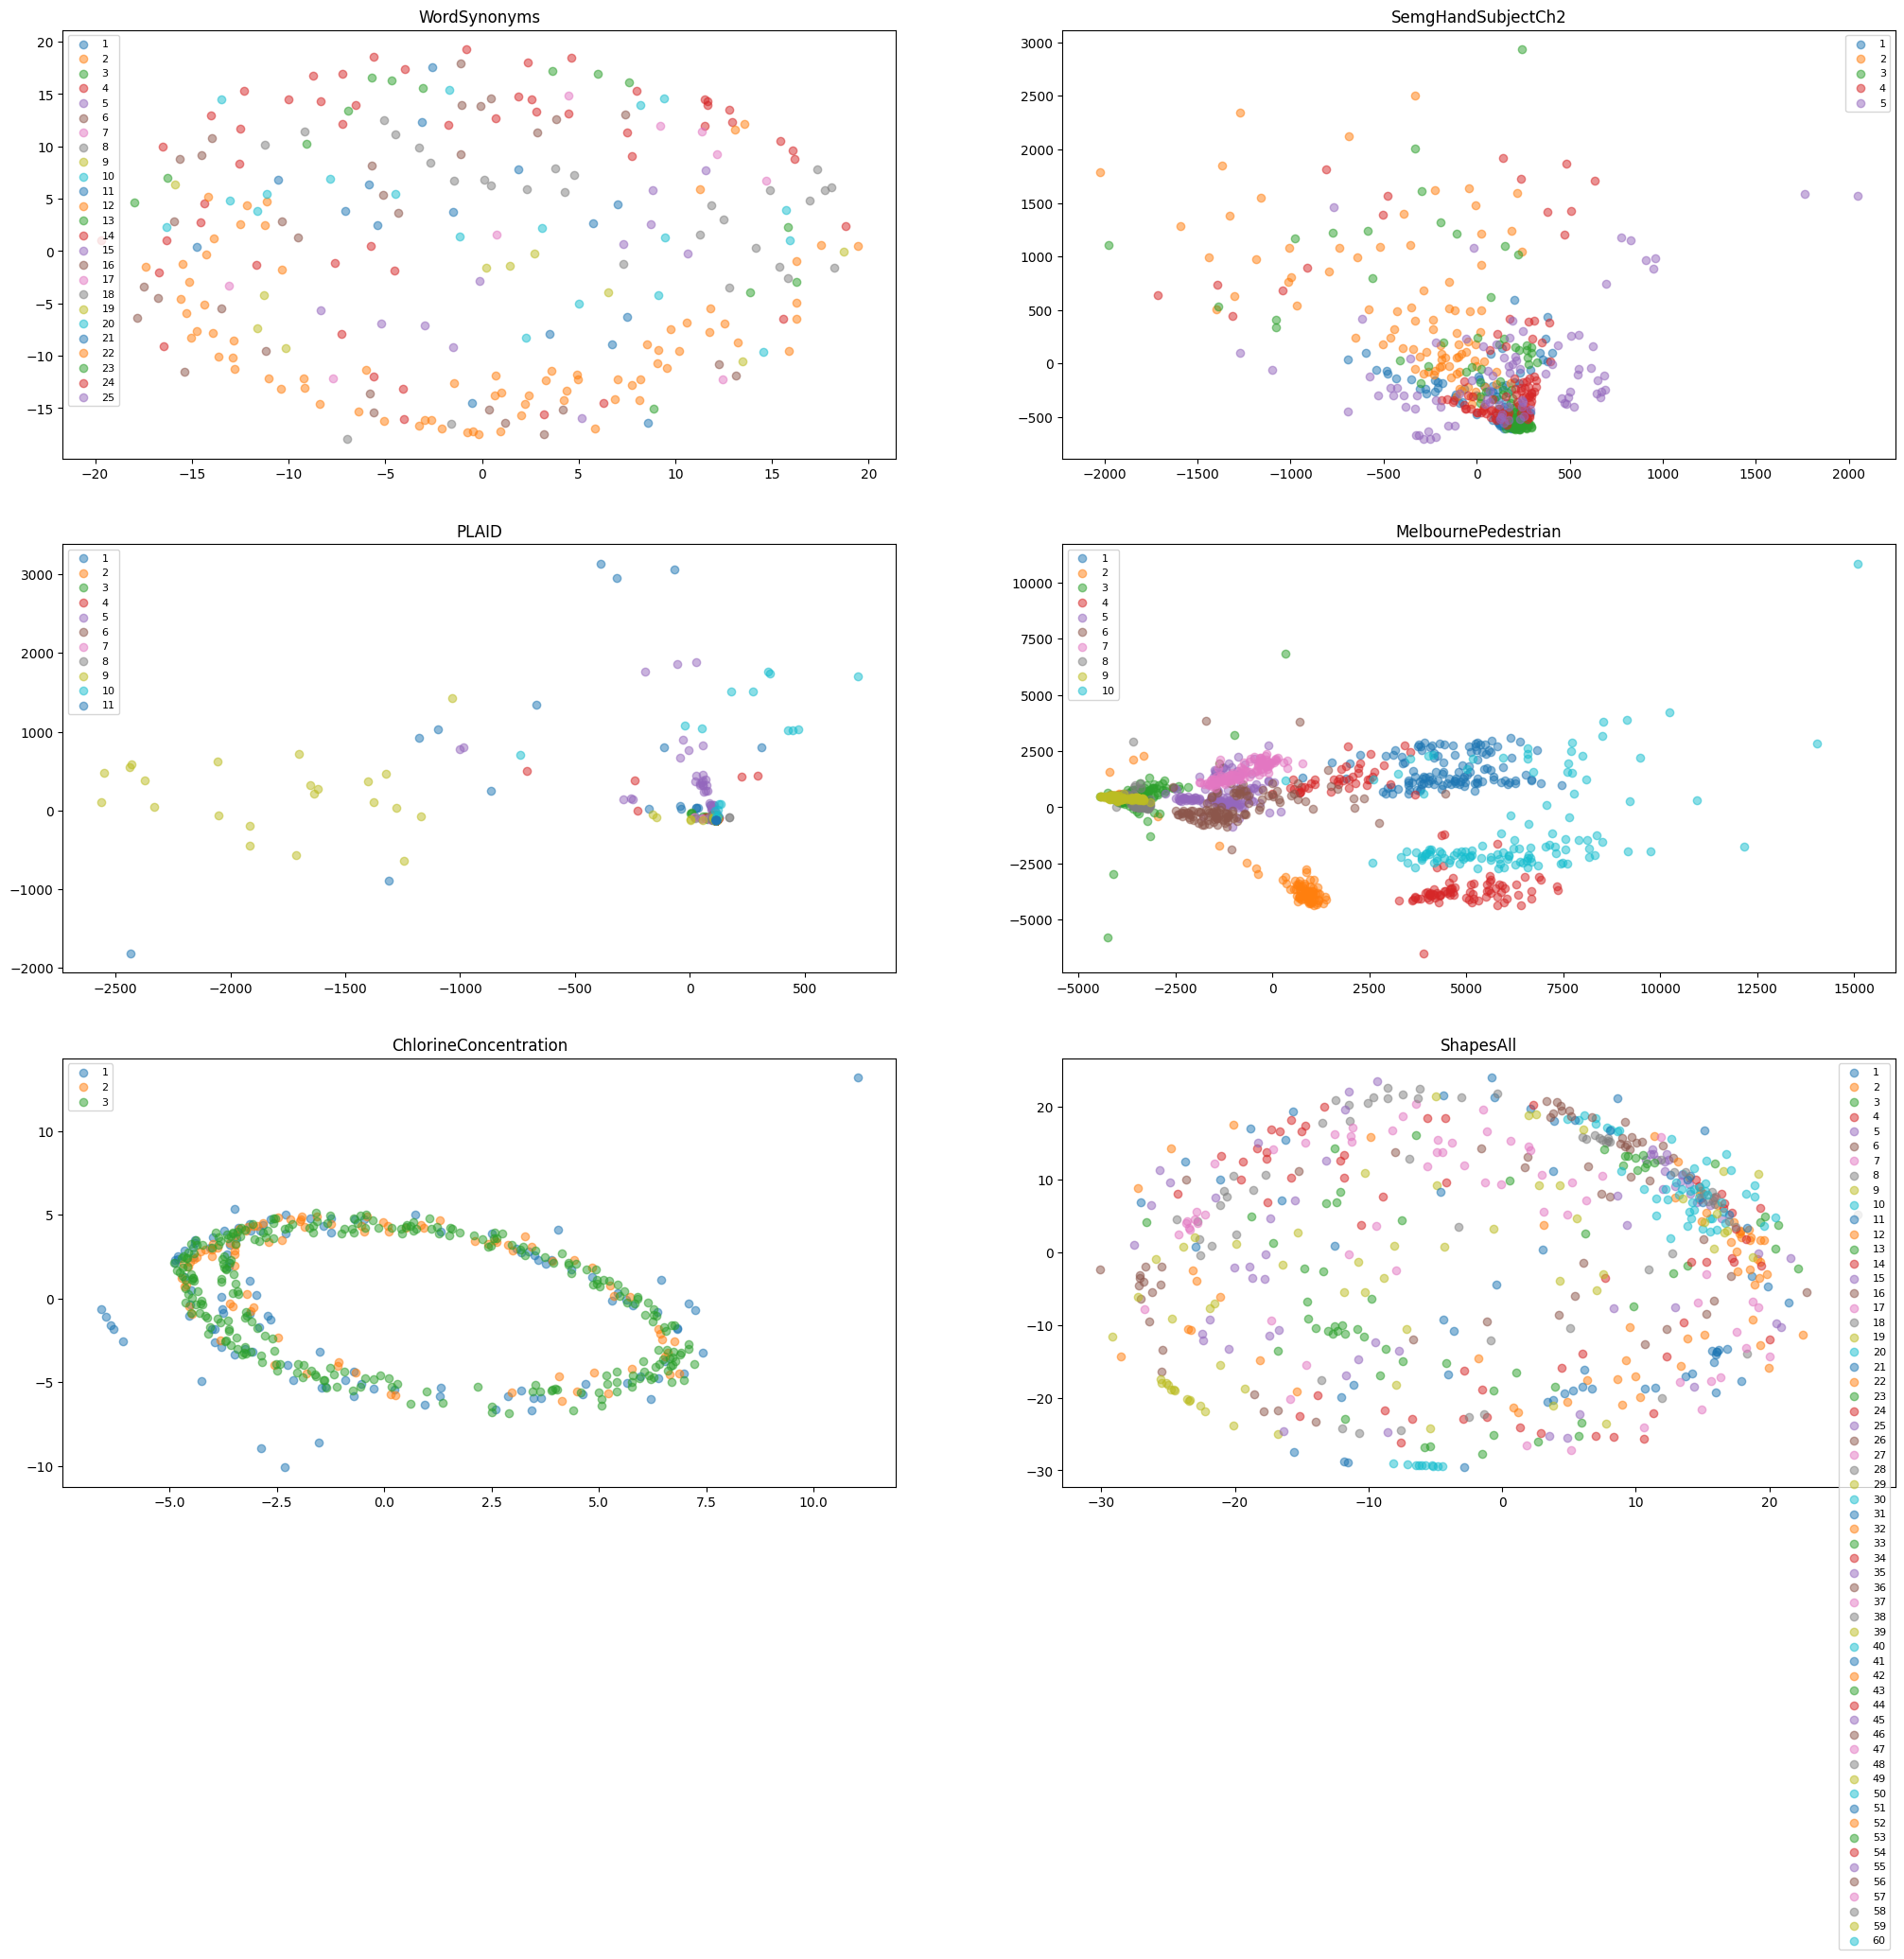

In [82]:
fig, axes = plt.subplots(3, 2, figsize=(25, 20))

def scatter_points(df_name, ax):
    X, y, X_test, y_test, df_errors = read_df(df_name)
    embedding = MDS(n_components=2)
    X_t = embedding.fit_transform(X)

    for cur_y in np.unique(y):
        ax.scatter(X_t[y==cur_y,0], X_t[y==cur_y,1], alpha=0.5)
    ax.legend(np.unique(y), fontsize=8, title_fontsize=8)
    ax.title.set_text(df_name)
    
for idx, df_name in enumerate(df_names):
    scatter_points(df_name, axes.flatten()[idx])

plt.savefig('scatter1.pdf')
plt.show()

### Teste de Hipotese (Nemenyi)

/tmp/ipykernel_99/1101899008.py:7: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = Orange.evaluation.compute_CD(avranks, df.shape[0],
/tmp/ipykernel_99/1101899008.py:9: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  Orange.evaluation.graph_ranks(avranks, df.keys(),


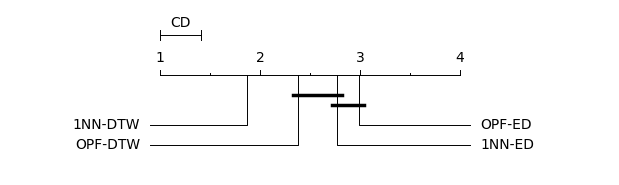

In [6]:
import Orange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

avranks = df.rank(axis=1,ascending=True).mean().values
cd = Orange.evaluation.compute_CD(avranks, df.shape[0], 
                                  alpha="0.05", test="nemenyi")
Orange.evaluation.graph_ranks(avranks, df.keys(), 
                              cd=cd, width=6, textspace=1.5)
plt.savefig('nemenyi2.pdf', bbox_inches='tight')
plt.show();

# Boxplot

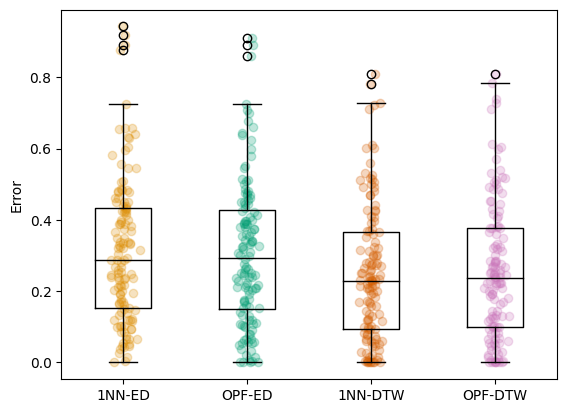

In [6]:
vals, names, xs = [],[],[]
for i, col in enumerate(df.columns):
    vals.append(df[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

boxplot = plt.boxplot(vals, labels=names)
for median in boxplot['medians']:
    median.set_color('black')
palette = sns.color_palette("colorblind")[1:5]
for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.25, color=c)
plt.ylabel('Error')
plt.savefig('boxplot.pdf', bbox_inches='tight')
plt.show()

# Info, win/draw/loss

In [7]:
for a in ['OPF-ED', 'OPF-DTW', '1NN-ED', '1NN-DTW']:
    for b in ['1NN-ED', '1NN-DTW']:
        win = np.sum(df[a] < df[b])
        draw = np.sum(df[a] == df[b])
        loss = np.sum(df[a] > df[b])
        assert(win+draw+loss == 128)

        print(f"{a} against {b}: {win}/{draw}/{loss}")

df.describe()

OPF-ED against 1NN-ED: 37/25/66
OPF-ED against 1NN-DTW: 35/7/86
OPF-DTW against 1NN-ED: 85/7/36
OPF-DTW against 1NN-DTW: 14/36/78
1NN-ED against 1NN-ED: 0/128/0
1NN-ED against 1NN-DTW: 38/4/86
1NN-DTW against 1NN-ED: 86/4/38
1NN-DTW against 1NN-DTW: 0/128/0


1NN-ED      OPF-ED     1NN-DTW     OPF-DTW
count  128.000000  128.000000  128.000000  128.000000
mean     0.313754    0.304500    0.250844    0.254512
std      0.203079    0.202302    0.190430    0.190778
min      0.000000    0.000000    0.000000    0.000000
25%      0.152175    0.149300    0.094200    0.099800
50%      0.288050    0.293750    0.229150    0.236300
75%      0.434575    0.426525    0.367300    0.377125
max      0.942300    0.908700    0.807700    0.807700

## More distant absolut differences

In [9]:
df.head()

1NN-ED  OPF-ED  1NN-DTW  OPF-DTW
0  0.4600  0.4600   0.3700   0.3800
1  0.3887  0.3964   0.3964   0.4041
2  0.4843  0.4757   0.2343   0.2543
3  0.4314  0.4743   0.2800   0.2857
4  0.5457  0.5514   0.3114   0.3186

In [37]:
df = pd.read_csv('all_errors.csv')
df = df[['name', '1NN-ED', 'OPF-ED', '1NN-DTW', 'OPF-DTW']]

idx = abs(df['OPF-DTW']-df['1NN-DTW']).sort_values(ascending=False).head(10).index.values
print(df.iloc[idx][['name', '1NN-DTW', 'OPF-DTW']].round(4).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                        name &  1NN-DTW &  OPF-DTW \\
\midrule
                   BeetleFly &   0.3000 &   0.2500 \\
            ToeSegmentation1 &   0.2281 &   0.2675 \\
                    OliveOil &   0.1667 &   0.1333 \\
 MiddlePhalanxOutlineCorrect &   0.3024 &   0.3333 \\
       SonyAIBORobotSurface2 &   0.1595 &   0.1868 \\
MiddlePhalanxOutlineAgeGroup &   0.5000 &   0.4740 \\
                   Computers &   0.4280 &   0.4520 \\
                     OSULeaf &   0.4091 &   0.4298 \\
                        Rock &   0.4800 &   0.5000 \\
          AllGestureWiimoteX &   0.2343 &   0.2543 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_384/807069293.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.iloc[idx][['name', '1NN-DTW', 'OPF-DTW']].round(4).to_latex(index=False))


## MST and OPF

In [5]:
from src.OPFInterface import OPFClassifier
from functools import cmp_to_key
import pandas as pd
import numpy as np
from os import listdir
from src.utils import error, read_df, euclidean_distance_classify
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("colorblind")
palette = [palette[1], palette[-1]]

X, y, X_test, y_test, df_errors = read_df("BirdChicken")
X = [X[7], X[8], X[9], X[12], X[10]]
y = [y[7], y[8], y[9], y[12], y[10]]

In [6]:
fig = make_subplots(rows=len(X), cols=1, subplot_titles=("1", "2", "3", "4", "5"))

for i in range(len(X)):
    fig.add_trace(go.Scatter(
        x=np.array(range(len(X[i]))), y=X[i],
        line_color=f'rgb{palette[y[i]%len(palette)]}'
    ), row=i+1, col=1)

    
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(visible=False, showticklabels=False)
fig.update_layout(
    showlegend=False,
    font_color="black",
    plot_bgcolor="white",
    margin=dict(t=20,l=10,b=10,r=10),
    height=300,
    width=150
)
fig.layout.annotations[0].update(x=0.0, font={'size': 14})
fig.layout.annotations[1].update(x=0.0, font={'size': 14})
fig.layout.annotations[2].update(x=0.0, font={'size': 14})
fig.layout.annotations[3].update(x=0.0, font={'size': 14})
fig.layout.annotations[4].update(x=0.0, font={'size': 14})

fig.show()
fig.write_image("series.pdf", width=150, height=300)

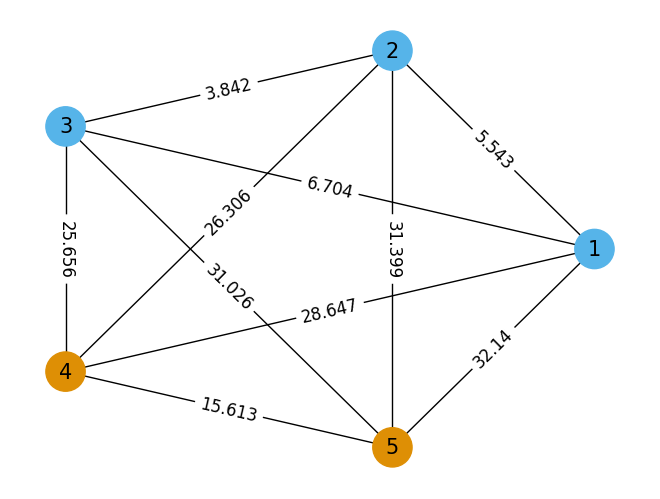

In [8]:
# Complete graph
import networkx as nx

opf = OptimumPathForestClassifier()
opf.fit(X, y)

G = nx.Graph(directed=False)
G.add_nodes_from(list(range(1, len(X)+1)))

for u in range(len(X)):
    for v in range(u+1, len(X)):
        G.add_edge(u+1, v+1, weight=round(opf.F(X[u], X[v]), 3))

pos=nx.circular_layout(G)
node_color = [palette[y[i]%len(palette)] for i in range(len(X))]

nx.draw(G, node_size=800, pos=pos, with_labels=True, node_color=node_color, font_size=15)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=12);

plt.savefig('complete.pdf')

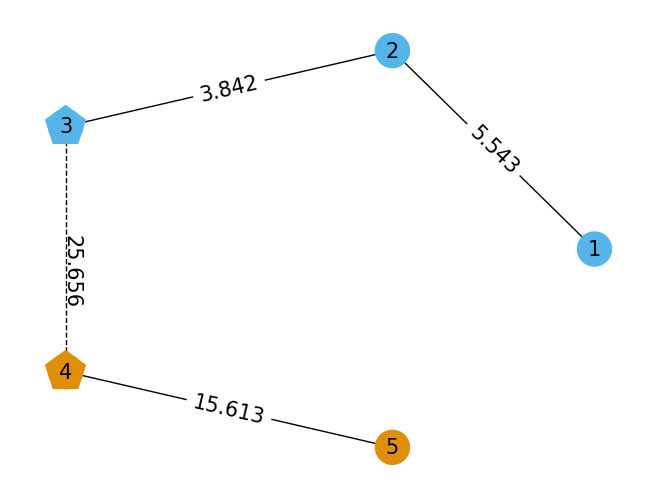

In [9]:
import networkx as nx

opf = OptimumPathForestClassifier()
opf.fit(X, y)

G = nx.Graph(directed=False)
G2 = nx.Graph(directed=False)
G.add_nodes_from(list(range(1, len(X)+1)))
G2.add_nodes_from([3, 4])

G2.add_edge(3, 4, weight=round(opf.F(X[2], X[3]), 3))

for u in range(len(X)):
    v = opf.parent[u]
    if v != -1:
        G.add_edge(u+1, v+1, weight=round(opf.F(X[u], X[v]), 3))

node_color = [palette[y[i]%len(palette)] for i in range(len(X))]

nx.draw(G, node_size=600, pos=pos, with_labels=True, node_color=node_color, font_size=15)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=15);

labels = nx.get_edge_attributes(G2,'weight')
nx.draw_networkx_edge_labels(G2, {k: [v[0]+0.02, v[1]+0.07] for k, v in pos.items()}, verticalalignment='top', edge_labels=labels, font_size=15);
nx.draw_networkx_edges(G2, pos, style='dashed')
nx.draw_networkx_nodes(G2, pos, node_size=900, node_shape='p', node_color=[palette[1], palette[0]])

plt.savefig('opf_forest.pdf')

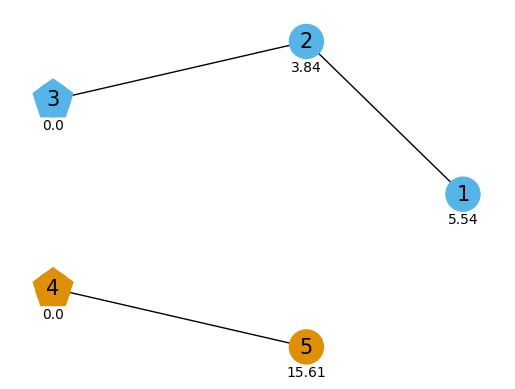

In [76]:
import networkx as nx

edges_tree = [
    [2, 3],
    [1, 2],
    [4, 5]
]

nodes_tree = [
#     1,
#     2,
#     3,
#     4,
#     5
]

palette = sns.color_palette("colorblind")
palette = [palette[7], palette[-1], palette[1]]

opf = OptimumPathForestClassifier()
opf.fit(X, y)


G_comp = nx.Graph(directed=False)
G_comp.add_nodes_from(list(range(1, len(X)+1)))

for u in range(len(X)):
    for v in range(u+1, len(X)):
        if [u+1, v+1] not in edges_tree:
            G_comp.add_edge(u+1, v+1, weight=round(opf.F(X[u], X[v]), 3))

pos=nx.circular_layout(G_comp)

nx.draw_networkx_edges(G_comp, pos=pos, style='--', width=0)
# nx.draw_networkx_edge_labels(G_comp,pos,edge_labels=nx.get_edge_attributes(G_comp,'weight'),font_size=8);


G = nx.Graph(directed=False)
G2 = nx.Graph(directed=False)
G.add_nodes_from(list(range(1, len(X)+1)))
G2.add_nodes_from([3, 4])
G2.add_edge(3, 4, weight=round(opf.F(X[2], X[3]), 3))
for xx in edges_tree:
    u, v = xx[0]-1, xx[1]-1
    G.add_edge(u+1, v+1, weight=round(opf.F(X[u], X[v]), 3))

node_color = [palette[y[i]] if i+1 not in nodes_tree else palette[0] for i in range(len(X))]
nx.draw(G, node_size=600, pos=pos, with_labels=True, node_color=node_color, font_size=15)
label_nodes = {i+1: f"{round(opf.cost[i], 2)}" for i in range(5)}
for i in nodes_tree:
    label_nodes[i] = ""
nx.draw_networkx_labels(G,
                        pos={k: [v[0], v[1]-0.16] for k, v in pos.items()},
                        labels=label_nodes,
                        font_size=10)
nx.draw_networkx_nodes(G2, pos, node_size=900, node_shape='p', node_color=[palette[y[i]] for i in [2, 3]])

plt.savefig('opf_forest_5.pdf')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]